In [1]:
from google.colab import files
import pandas as pd
import io
import numpy as np

uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving diabetes.csv to diabetes.csv


In [2]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[columns])
df_scaled = pd.DataFrame(df_scaled, columns=columns)
imputer = KNNImputer(n_neighbors=5)
df_scaled_imputed = imputer.fit_transform(df_scaled)
df_scaled_imputed = pd.DataFrame(df_scaled_imputed, columns=columns)

df.update(df_scaled_imputed)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
df['Outcome'] = df['Outcome'].replace({0: -1, 1: 1})
features = df.columns.drop('Outcome')
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Outcome'], test_size=0.3, random_state=0)
class_weights = {-1: 1, 1: 1}
model = LogisticRegression(class_weight=class_weights)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy of the Logistic Regression model:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy of the Logistic Regression model: 0.7619047619047619
Confusion Matrix:
 [[140  17]
 [ 38  36]]


Accuracy: 0.7619047619047619
Confusion Matrix:
 [[140  17]
 [ 38  36]]
Precision: 0.6792452830188679
Recall: 0.4864864864864865
ROC AUC: 0.8358581511447754


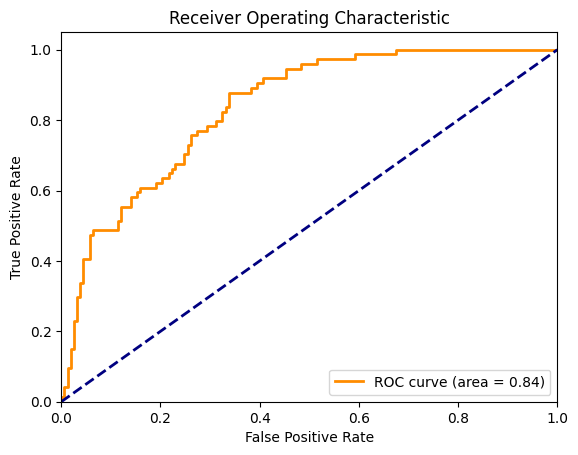

In [5]:
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC:", roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [6]:
feature_importance = pd.DataFrame(model.coef_[0], index=features, columns=['Coefficient'])
print(feature_importance.sort_values(by='Coefficient', ascending=False))

                          Coefficient
Glucose                      1.118121
BMI                          0.674482
Pregnancies                  0.315157
Age                          0.263249
DiabetesPedigreeFunction     0.231419
Insulin                     -0.010861
SkinThickness               -0.023740
BloodPressure               -0.176782


In [7]:
import requests
import zipfile
import io
import pandas as pd

zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"

# Send a HTTP request to the URL
response = requests.get(zip_url)
# Check if the request was successful
if response.status_code == 200:
    # Open the ZIP file
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        # Extract 'diabetic_data.csv' and load it into a DataFrame
        with thezip.open('dataset_diabetes/diabetic_data.csv') as myfile:
            df_actual = pd.read_csv(myfile)
else:
    print("Failed to download the file")

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fill missing values in 'A1Cresult' with 'none'
df_actual['A1Cresult'] = df_actual['A1Cresult'].fillna('none')

# Grouping primary diagnosis codes into broader categories
def categorize_diag(diag):
    if diag.startswith('250'):
        return 'Diabetes'
    elif diag.startswith(('390', '459')):
        return 'Circulatory'
    elif diag.startswith(('460', '519')):
        return 'Respiratory'
    else:
        return 'Other'

df_actual['diag_group'] = df_actual['diag_1'].apply(categorize_diag)

# Bivariate Analysis: HbA1c vs Medication Change
a1c_med_change = pd.crosstab(df_actual['A1Cresult'], df_actual['change'], normalize='index')
print("\nA1Cresult vs Medication Change:\n", a1c_med_change)

# Analysis: Measured vs Not Measured HbA1c and Medication Change
df_actual['A1C_measured'] = df_actual['A1Cresult'].apply(lambda x: 'Measured' if x != 'none' else 'Not Measured')
a1c_measured_med_change = pd.crosstab(df_actual['A1C_measured'], df_actual['change'], normalize='index')
print("\nA1C Measured vs Medication Change:\n", a1c_measured_med_change)

# Analysis: Measured vs Not Measured HbA1c and Readmission
a1c_measured_read = pd.crosstab(df_actual['A1C_measured'], df_actual['readmitted'], normalize='index')
print("\nA1C Measured vs Readmission:\n", a1c_measured_read)

# Trivariate Analysis: A1C Measured vs Readmission stratified by Primary Diagnosis
a1c_measured_read_diag = pd.crosstab([df_actual['A1C_measured'], df_actual['diag_group']], df_actual['readmitted'], normalize='index')
print("\nA1C Measured vs Readmission stratified by Primary Diagnosis:\n", a1c_measured_read_diag)


A1Cresult vs Medication Change:
 change           Ch        No
A1Cresult                    
>7         0.507608  0.492392
>8         0.651047  0.348953
Norm       0.442084  0.557916
none       0.442736  0.557264

A1C Measured vs Medication Change:
 change              Ch        No
A1C_measured                    
Measured      0.557645  0.442355
Not Measured  0.442736  0.557264

A1C Measured vs Readmission:
 readmitted         <30       >30        NO
A1C_measured                              
Measured      0.098484  0.340816  0.560700
Not Measured  0.114233  0.350982  0.534785

A1C Measured vs Readmission stratified by Primary Diagnosis:
 readmitted                     <30       >30        NO
A1C_measured diag_group                               
Measured     Circulatory  0.000000  0.500000  0.500000
             Diabetes     0.095428  0.339985  0.564586
             Other        0.099207  0.340939  0.559854
             Respiratory  0.000000  0.142857  0.857143
Not Measured Circulat